# Linear Probing on `cached_activations_3`

**Owner:** *Zurabi Kochiashvili*

**Purpose:** Train and evaluate per-layer linear probes on `cached_activations_3` with correct label normalization (`1 = pivotal`, `-1 -> 0 = non-pivotal`, `0 = unused`), 1:1 training balance, stratified splits (if needed), and complete artifacts (CSV + confusion matrices + mini report).



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1) Environment & imports
**What this does**
- Imports standard libraries (PyTorch, scikit-learn, pandas, matplotlib, numpy, tqdm).
- Sets deterministic seeds for reproducibility.
- If running on Colab and a package is missing, uncomment the `pip install` line.


In [ ]:
# If running on Colab, you can install (usually already present):
# !pip install -q torch torchvision torchaudio scikit-learn matplotlib numpy pandas tqdm

import os, json, math, random
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.auto import tqdm

%config InlineBackend.figure_format = 'retina'

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


## 2) Configuration
**How to use**
- Point the paths below to your `cached_activations_3` folder.
- This notebook supports either:
  1) Train/Test split files: `train_all_layers_acts.pth` and `test_all_layers_acts.pth` (preferred), each containing activations `[N, L, D]` and labels.
  2) Single file or per-layer files (fallback mode).

**Balancing & evaluation**
- We balance the training set to **1:1** (under-sample majority) and do **not** balance the test set.
- If train/test files are provided, we use them directly (no extra splitting). Otherwise we create a stratified split.


In [ ]:
# =====================
# CONFIGURATION
# =====================
BASE_DIR = "/content/drive/MyDrive/cached_activations_3"   # <-- EDIT
TRAIN_FILE = os.path.join(BASE_DIR, "train_all_layers_acts.pth")  # <-- EDIT (exists)
TEST_FILE  = os.path.join(BASE_DIR,  "test_all_layers_acts.pth")  # <-- EDIT (exists)

# If you DON'T have the two files above, optionally use a single All-Layers file or per-layer pattern:
SINGLE_FILE_PATH = None          # e.g., os.path.join(BASE_DIR, "all_layers_acts.pt")
PER_LAYER_PATTERN = None         # e.g., os.path.join(BASE_DIR, "layer_{idx}.pt")
NUM_LAYERS = 32                  # set if using per-layer pattern
TENSOR_KEY = None                # if .pth/.pt is a dict, specify key for activations (e.g., "acts")

# Labels: If labels are embedded inside the .pth (recommended), no need to set extra paths.
# If labels are separate, set these (None otherwise):
TRAIN_LABELS_PATH = None         # e.g., os.path.join(BASE_DIR, "train_labels.pt")
TEST_LABELS_PATH  = None         # e.g., os.path.join(BASE_DIR, "test_labels.pt")

# Behavior flags
KEEP_UNUSED_ZERO = False   # If True: keep label==0 (treated as non-pivotal). If False: drop 'unused' (0) before splitting.
BALANCE_TRAIN_1_TO_1 = True
USE_STRATIFY = True        # used only when we must derive a split
TEST_SIZE = 0.2            # ignored when TRAIN/TEST files are provided

# Model hyperparameters
LOGREG_MAX_ITERS = 2000
LOGREG_C = 1.0
LOGREG_N_JOBS = -1

# Runtime
OUTPUT_DIR = "/content/drive/MyDrive/linear_probe_outputs_zurabi"  # <-- EDIT
QUICK_TEST = False
MAX_EXAMPLES = None


In [ ]:
import os
print("Train exists:", os.path.exists(TRAIN_FILE))
print("Test  exists:", os.path.exists(TEST_FILE))
print("Output dir:", OUTPUT_DIR)



Train exists: True
Test  exists: True
Output dir: /content/drive/MyDrive/linear_probe_outputs_zurabi


## 3) Utility functions
- `ensure_dir`: creates output directories.
- `coerce_tensor`: converts Python/PyTorch objects to CPU tensors.
- `load_split_from_file`: robust loader for `.pth/.pt` that may store activations/labels as tensors or in a dict.
- `normalize_labels`: enforces `-1 -> 0`, optionally drops `0` (unused) examples.
- `undersample_to_balance`: makes 1:1 class balance for training.
- `compute_metrics` and `plot_and_save_cm`: reporting helpers.


In [ ]:
def ensure_dir(p):
    os.makedirs(p, exist_ok=True)

def coerce_tensor(obj):
    if isinstance(obj, torch.Tensor):
        return obj.detach().cpu()
    if isinstance(obj, (np.ndarray, list)):
        return torch.as_tensor(obj)
    raise ValueError("Unsupported tensor-like object type")

def load_split_from_file(path, labels_path=None, tensor_key=None, quick=False, max_examples=200):
    """
    Loads a split file. Accepts:
    - Tensor with shape [N, L, D], OR
    - Dict with keys like {'acts': [N, L, D], 'labels': [N]} (keys are flexible - tensor_key helps for acts).
    If labels_path is provided, it overrides any labels found inside the file.
    Returns: acts_np [N, L, D], labels_np [N]
    """
    obj = torch.load(path, map_location="cpu")
    acts = None
    labels = None

    if isinstance(obj, dict):
        # Choose activations
        if tensor_key is not None and tensor_key in obj:
            acts = coerce_tensor(obj[tensor_key])
        else:
            for k, v in obj.items():
                if isinstance(v, torch.Tensor) and v.ndim >= 2:
                    acts = coerce_tensor(v)
                    break
        # Choose labels
        for k, v in obj.items():
            if ("label" in k.lower()) and isinstance(v, torch.Tensor) and v.ndim >= 1:
                labels = coerce_tensor(v).view(-1)
                break
    elif isinstance(obj, torch.Tensor):
        acts = obj.detach().cpu()
    else:
        raise ValueError("Unsupported .pth/.pt structure")

    # If labels are provided separately, load them
    if labels_path is not None:
        lp = os.path.splitext(labels_path)[1].lower()
        if lp in [".pt", ".pth"]:
            lobj = torch.load(labels_path, map_location="cpu")
            if isinstance(lobj, dict) and "labels" in lobj:
                labels = coerce_tensor(lobj["labels"]).view(-1)
            else:
                labels = coerce_tensor(lobj).view(-1)
        elif lp == ".npy":
            labels = torch.as_tensor(np.load(labels_path)).view(-1)
        else:
            raise ValueError("Unsupported labels file")

    if acts is None:
        raise ValueError("Could not locate activations in file")
    if labels is None:
        raise ValueError("Could not locate labels - embed them in the .pth or provide *_LABELS_PATH")

    acts = acts.float()
    if quick:
        acts = acts[:max_examples]
        labels = labels[:max_examples]

    return acts.numpy(), labels.numpy()

def normalize_labels(y, keep_unused_zero=False):
    y = y.copy()
    # Map -1 -> 0 (non-pivotal)
    y[y == -1] = 0
    if keep_unused_zero:
        mask = np.ones_like(y, dtype=bool)
    else:
        # Drop 'unused' zeros if any exist (assumes 0 may include 'unused')
        mask = (y == 0) | (y == 1)
    return y[mask], mask

def undersample_to_balance(X, y, seed=42):
    cls0_idx = np.where(y == 0)[0]
    cls1_idx = np.where(y == 1)[0]
    if len(cls0_idx) == 0 or len(cls1_idx) == 0:
        return X, y
    n = min(len(cls0_idx), len(cls1_idx))
    rng = np.random.default_rng(seed)
    cls0_sel = rng.choice(cls0_idx, size=n, replace=False)
    cls1_sel = rng.choice(cls1_idx, size=n, replace=False)
    idx = np.concatenate([cls0_sel, cls1_sel])
    rng.shuffle(idx)
    return X[idx], y[idx]

def compute_metrics(y_true, y_pred, y_proba=None):
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    cm = confusion_matrix(y_true, y_pred)
    roc = None
    if y_proba is not None:
        try:
            roc = roc_auc_score(y_true, y_proba)
        except Exception:
            roc = None
    if cm.size == 4:
        tn, fp, fn, tp = cm.ravel()
    else:
        tn = fp = fn = tp = np.nan
    return {
        "accuracy": acc, "f1": f1, "precision": prec, "recall": rec,
        "tn": tn, "fp": fp, "fn": fn, "tp": tp, "roc_auc": roc, "cm": cm
    }

def plot_and_save_cm(cm, out_png, title="Confusion Matrix"):
    fig = plt.figure(figsize=(4,3))
    ax = fig.add_subplot(111)
    ax.imshow(cm, interpolation='nearest')
    ax.set_title(title)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
    for (i, j), val in np.ndenumerate(cm):
        ax.text(j, i, f"{val}", ha='center', va='center')
    fig.tight_layout()
    fig.savefig(out_png, dpi=200)
    plt.close(fig)


In [ ]:
# --- PATCH: robust loader for .pth splits with mixed key types / formats ---
import torch, numpy as np, os

def _coerce_tensor(obj):
    if isinstance(obj, torch.Tensor):
        return obj.detach().cpu()
    if isinstance(obj, (np.ndarray, list)):
        return torch.as_tensor(obj)
    return None

def _stack_per_layer_dict(d):
    """If dict has int-like keys {0: [N,D], 1: [N,D], ...}, stack -> [N,L,D]."""
    items = []
    for k, v in d.items():
        try:
            ik = int(k)
            if isinstance(v, torch.Tensor) and v.ndim == 2:
                items.append((ik, v.detach().cpu()))
        except Exception:
            continue
    if not items:
        return None
    items = sorted(items, key=lambda x: x[0])
    arrs = [t.numpy() for _, t in items]  # [L, N, D]
    acts = np.stack(arrs, axis=0)         # [L, N, D]
    acts = np.transpose(acts, (1, 0, 2))  # -> [N, L, D]
    return acts

def load_split_from_file(path, labels_path=None, tensor_key=None, quick=False, max_examples=200):
    """
    Loads a split file with minimal assumptions. Supports:
      - dict with keys like 'acts'/'activations'/'features' and 'labels'
      - single tensor [N, L, D]
      - dict of per-layer tensors with int keys {0:[N,D],1:[N,D],...}  -> stacked to [N,L,D]
      - tuple/list (acts, labels)
    If labels_path is provided, it overrides embedded labels.
    Returns: acts_np [N, L, D], labels_np [N]
    """
    obj = torch.load(path, map_location="cpu")

    acts = None
    labels = None

    # 1) Tuple/list (acts, labels)
    if isinstance(obj, (tuple, list)) and len(obj) == 2:
        a, l = obj
        a = _coerce_tensor(a); l = _coerce_tensor(l)
        if a is not None and l is not None:
            acts = a.float().numpy()
            labels = l.view(-1).numpy()

    # 2) Raw tensor [N, L, D]
    if acts is None and isinstance(obj, torch.Tensor) and obj.ndim >= 3:
        acts = obj.detach().cpu().float().numpy()

    # 3) Dict formats
    if acts is None and isinstance(obj, dict):
        # 3a) If user knows the key
        if tensor_key is not None and tensor_key in obj:
            t = _coerce_tensor(obj[tensor_key])
            if t is not None:
                acts = t.float().numpy()

        # 3b) Common string keys
        if acts is None:
            for k, v in obj.items():
                ks = str(k).lower()
                if isinstance(v, torch.Tensor) and v.ndim >= 3 and any(s in ks for s in ["act", "feat", "hidden"]):
                    acts = v.detach().cpu().float().numpy()
                    break
        # 3c) Any 3D tensor
        if acts is None:
            for k, v in obj.items():
                if isinstance(v, torch.Tensor) and v.ndim >= 3:
                    acts = v.detach().cpu().float().numpy()
                    break
        # 3d) Per-layer dict {0:[N,D],1:[N,D],...}
        if acts is None:
            acts = _stack_per_layer_dict(obj)

        # Labels: prefer explicit name
        for k, v in obj.items():
            ks = str(k).lower()
            if "label" in ks or "target" in ks or ks in {"y", "y_train", "ytest", "labels"}:
                vt = _coerce_tensor(v)
                if isinstance(vt, torch.Tensor) and vt.ndim >= 1:
                    labels = vt.view(-1)
                    break
        # If still none, try any 1D tensor as labels
        if labels is None:
            for k, v in obj.items():
                if isinstance(v, torch.Tensor) and v.ndim == 1:
                    labels = v.view(-1)
                    break
        if labels is not None:
            labels = labels.detach().cpu().numpy()

    # 4) External labels override
    if labels_path is not None:
        ext = os.path.splitext(labels_path)[1].lower()
        if ext in [".pt", ".pth"]:
            lobj = torch.load(labels_path, map_location="cpu")
            if isinstance(lobj, dict) and "labels" in lobj:
                labels = _coerce_tensor(lobj["labels"]).view(-1).numpy()
            else:
                labels = _coerce_tensor(lobj).view(-1).numpy()
        elif ext == ".npy":
            import numpy as _np
            labels = _np.load(labels_path).reshape(-1)

    if acts is None or labels is None:
        # Light introspection to help you set TENSOR_KEY or confirm format
        print("Could not auto-detect activations/labels from:", path)
        if isinstance(obj, dict):
            print("Available keys and shapes:")
            for k, v in obj.items():
                shp = getattr(v, "shape", None) if isinstance(v, torch.Tensor) else type(v)
                print(f"  - {k!r}: {shp}")
        raise ValueError("Failed to parse activations/labels. Consider setting TENSOR_KEY or sharing key names.")

    # Quick subset
    if quick:
        acts = acts[:max_examples]
        labels = labels[:max_examples]

    # Ensure shape [N, L, D]
    if acts.ndim == 2:
        # If you ever get [N, D] per layer from somewhere else, add a fake L=1
        acts = acts[:, None, :]

    return acts, labels


In [ ]:
# --- PATCH 2: loader for nested dict-of-dicts {layer_idx: { ...tensors... }} ---
import torch, numpy as np, os

def _coerce_cpu(t):
    return t.detach().cpu() if isinstance(t, torch.Tensor) else None

def _pick_acts(inner):
    # Prefer names with act/feat/hidden/x, else first 2D tensor
    for k, v in inner.items():
        ks = str(k).lower()
        if isinstance(v, torch.Tensor) and v.ndim == 2 and any(s in ks for s in ["act","feat","hidden","x"]):
            return _coerce_cpu(v)
    for k, v in inner.items():
        if isinstance(v, torch.Tensor) and v.ndim == 2:
            return _coerce_cpu(v)
    return None

def _pick_labels(inner):
    # Look for labels/targets/y; allow 1D or squeezable
    for k, v in inner.items():
        ks = str(k).lower()
        if isinstance(v, torch.Tensor) and v.ndim >= 1 and ("label" in ks or "target" in ks or ks in {"y","labels"}):
            return _coerce_cpu(v).view(-1)
    return None

def load_split_from_file(path, labels_path=None, tensor_key=None, quick=False, max_examples=200):
    """
    Supports:
      - dict of per-layer dicts: {0: {...}, 1: {...}, ...}, each inner dict contains a [N,D] tensor
      - (also still supports earlier formats: tuple(acts,labels), single 3D tensor, dict with 3D acts & labels)
    Returns: acts_np [N, L, D], labels_np [N]
    """
    obj = torch.load(path, map_location="cpu")

    # 1) If tuple/list(acts, labels)
    if isinstance(obj, (tuple, list)) and len(obj) == 2:
        acts, labels = obj
        acts = _coerce_cpu(acts).float().numpy()
        labels = _coerce_cpu(labels).view(-1).numpy()
        if quick:
            acts, labels = acts[:max_examples], labels[:max_examples]
        if acts.ndim == 2: acts = acts[:, None, :]
        return acts, labels

    # 2) If already a 3D tensor
    if isinstance(obj, torch.Tensor) and obj.ndim >= 3:
        acts = _coerce_cpu(obj).float().numpy()
        if quick: acts = acts[:max_examples]
        # Need external labels for this case
        if labels_path is None:
            raise ValueError("3D tensor provided but no labels_path given.")
        ext = os.path.splitext(labels_path)[1].lower()
        if ext in [".pt", ".pth"]:
            l = torch.load(labels_path, map_location="cpu")
            if isinstance(l, dict) and "labels" in l: l = l["labels"]
            labels = _coerce_cpu(l).view(-1).numpy()
        else:
            labels = np.load(labels_path).reshape(-1)
        if quick: labels = labels[:max_examples]
        return acts, labels

    # 3) If dict
    if isinstance(obj, dict):
        # 3a) dict of per-layer dicts? (your case)
        try:
            layer_keys = sorted([int(k) for k in obj.keys()])
            if layer_keys and isinstance(obj[layer_keys[0]], dict):
                acts_list = []
                labels = None
                for lk in layer_keys:
                    inner = obj[lk]
                    a = _pick_acts(inner)
                    if a is None:
                        continue
                    if quick: a = a[:max_examples]
                    acts_list.append(a)
                    if labels is None:
                        l = _pick_labels(inner)
                        if l is not None:
                            labels = l
                            if quick: labels = labels[:max_examples]
                if not acts_list:
                    raise ValueError("No [N,D] activation tensors found in inner dicts.")
                acts = torch.stack(acts_list, dim=1).float().numpy()  # [N, L, D]
                if labels is None:
                    raise ValueError("No labels found in inner dicts. Provide external labels or tell me the key name.")
                return acts, labels.numpy() if isinstance(labels, torch.Tensor) else labels
        except Exception:
            pass

        # 3b) dict with 3D acts + labels under string keys
        # try tensor_key, then try common names, then any 3D tensor
        acts = None; labels = None
        if tensor_key is not None and tensor_key in obj:
            acts = _coerce_cpu(obj[tensor_key]).float().numpy()
        if acts is None:
            for k, v in obj.items():
                ks = str(k).lower()
                if isinstance(v, torch.Tensor) and v.ndim >= 3 and any(s in ks for s in ["act","feat","hidden"]):
                    acts = _coerce_cpu(v).float().numpy(); break
        if acts is None:
            for k, v in obj.items():
                if isinstance(v, torch.Tensor) and v.ndim >= 3:
                    acts = _coerce_cpu(v).float().numpy(); break
        if acts is not None:
            for k, v in obj.items():
                ks = str(k).lower()
                if isinstance(v, torch.Tensor) and v.ndim >= 1 and ("label" in ks or "target" in ks or ks in {"y","labels"}):
                    labels = _coerce_cpu(v).view(-1).numpy(); break
            if labels is None:
                # any 1D tensor
                for k, v in obj.items():
                    if isinstance(v, torch.Tensor) and v.ndim == 1:
                        labels = _coerce_cpu(v).view(-1).numpy(); break
            if quick and acts is not None:
                acts = acts[:max_examples]
                if labels is not None: labels = labels[:max_examples]
            if labels is None:
                raise ValueError("Found acts but not labels; provide labels_path or tell me label key.")
            if acts.ndim == 2: acts = acts[:, None, :]
            return acts, labels

    # If nothing matched:
    print("Could not parse structure of:", path)
    raise ValueError("Unsupported .pth format for this loader.")


In [ ]:
# --- PATCH 3: robust loader for nested dict-of-dicts (.pth) ---
import os, torch, numpy as np

def _to_cpu(t):
    return t.detach().cpu() if isinstance(t, torch.Tensor) else None

def _is_acts_tensor(v):   # prefer 2D [N,D], accept >=2D
    return isinstance(v, torch.Tensor) and v.ndim >= 2

def _is_label_tensor(v):  # prefer 1D, accept >=1D (we'll flatten)
    return isinstance(v, torch.Tensor) and v.ndim >= 1

_ACT_KEYS = ("act","feat","hidden","emb","x")   # activation-ish
_LAB_KEYS = ("label","target","pivot","y","cls")

def _pick_activation(inner):
    # Try by name
    for k, v in inner.items():
        ks = str(k).lower()
        if any(s in ks for s in _ACT_KEYS) and _is_acts_tensor(v):
            return _to_cpu(v)
    # Fall back: first 2D+ tensor
    for k, v in inner.items():
        if _is_acts_tensor(v):
            return _to_cpu(v)
    return None

def _pick_labels(inner):
    # Try by name
    for k, v in inner.items():
        ks = str(k).lower()
        if any(s in ks for s in _LAB_KEYS) and _is_label_tensor(v):
            return _to_cpu(v).view(-1)
    # Fall back: first 1D tensor
    for k, v in inner.items():
        if _is_label_tensor(v) and v.ndim == 1:
            return _to_cpu(v).view(-1)
    return None

def load_split_from_file(path, labels_path=None, tensor_key=None, quick=False, max_examples=200):
    """
    Handles:
      - dict of per-layer dicts: {0: {...}, 1: {...}, ...}
      - dict with 3D acts + labels under string keys (with weird names)
      - tuple/list(acts, labels)
      - raw 3D tensor (labels must be provided separately)
      - top-level labels with per-layer acts inside inner dicts
    Returns: acts_np [N, L, D], labels_np [N]
    """
    obj = torch.load(path, map_location="cpu")

    # (A) tuple/list (acts, labels)
    if isinstance(obj, (tuple, list)) and len(obj) == 2:
        a, l = obj
        a = _to_cpu(a); l = _to_cpu(l)
        if a is None or l is None: raise ValueError("Tuple did not contain tensors")
        acts = a.float().numpy()
        labels = l.view(-1).numpy()
        if quick: acts, labels = acts[:max_examples], labels[:max_examples]
        if acts.ndim == 2: acts = acts[:, None, :]
        return acts, labels

    # (B) raw 3D tensor
    if isinstance(obj, torch.Tensor) and obj.ndim >= 3:
        acts = _to_cpu(obj).float().numpy()
        if labels_path is None:
            raise ValueError("Found 3D acts but no labels_path. Provide TRAIN_LABELS_PATH/TEST_LABELS_PATH.")
        ext = os.path.splitext(labels_path)[1].lower()
        if ext in [".pt", ".pth"]:
            lobj = torch.load(labels_path, map_location="cpu")
            if isinstance(lobj, dict) and "labels" in lobj: lobj = lobj["labels"]
            labels = _to_cpu(lobj).view(-1).numpy()
        else:
            labels = np.load(labels_path).reshape(-1)
        if quick: acts, labels = acts[:max_examples], labels[:max_examples]
        return acts, labels

    # (C) dict-ish top level
    if isinstance(obj, dict):
        # (C1) Try dict-of-dicts per layer: {layer_idx: {...}}
        layer_keys = list(obj.keys())
        if layer_keys and all(isinstance(obj[k], dict) for k in layer_keys):
            # try to sort numerically where possible, else keep order
            try:
                order = sorted(layer_keys, key=lambda k: int(k))
            except Exception:
                order = layer_keys

            acts_list = []
            labels = None

            # also check if top-level has labels once
            top_labels = None
            for k, v in obj.items():
                ks = str(k).lower()
                if any(s in ks for s in _LAB_KEYS) and _is_label_tensor(v):
                    top_labels = _to_cpu(v).view(-1)

            for lk in order:
                inner = obj[lk]
                a = _pick_activation(inner)
                if a is None:
                    continue
                if a.ndim > 2:
                    # squish extra dims if needed (e.g., [N,D,?] -> [N,D*?])
                    a = a.flatten(1)
                if quick: a = a[:max_examples]
                acts_list.append(a)

                if labels is None:
                    l = _pick_labels(inner)
                    if l is not None:
                        labels = l

            if not acts_list:
                # No per-layer 2D tensors found; bail to other strategy
                pass
            else:
                # stack to [L, N, D] -> [N, L, D]
                try:
                    arrs = [t.numpy() for t in acts_list]  # each [N,D]
                except:
                    arrs = [np.asarray(t) for t in acts_list]
                acts = np.stack(arrs, axis=0)   # [L,N,D]
                acts = np.transpose(acts, (1,0,2))  # [N,L,D]
                if labels is None and top_labels is not None:
                    labels = top_labels
                if labels is None:
                    raise ValueError("No labels found (neither per-layer nor top-level). Provide *_LABELS_PATH or tell me the label key.")
                labels = labels.numpy() if isinstance(labels, torch.Tensor) else np.asarray(labels)
                if quick: labels = labels[:acts.shape[0]]
                return acts[:labels.shape[0]], labels

        # (C2) dict with 3D acts somewhere + labels
        # try tensor_key, then common names, then any 3D tensor
        acts = None; labels = None
        if tensor_key is not None and tensor_key in obj:
            acts = _to_cpu(obj[tensor_key]).float().numpy()
        if acts is None:
            for k, v in obj.items():
                if isinstance(v, torch.Tensor) and v.ndim >= 3 and any(s in str(k).lower() for s in _ACT_KEYS):
                    acts = _to_cpu(v).float().numpy(); break
        if acts is None:
            for k, v in obj.items():
                if isinstance(v, torch.Tensor) and v.ndim >= 3:
                    acts = _to_cpu(v).float().numpy(); break
        if acts is not None:
            for k, v in obj.items():
                if any(s in str(k).lower() for s in _LAB_KEYS) and _is_label_tensor(v):
                    labels = _to_cpu(v).view(-1).numpy(); break
            if labels is None:
                for k, v in obj.items():
                    if _is_label_tensor(v) and v.ndim == 1:
                        labels = _to_cpu(v).view(-1).numpy(); break
            if quick:
                acts = acts[:max_examples]
                if labels is not None: labels = labels[:max_examples]
            if labels is None:
                raise ValueError("Found 3D acts but no labels. Provide *_LABELS_PATH or label key.")
            if acts.ndim == 2: acts = acts[:, None, :]
            return acts, labels

    # Nothing matched
    raise ValueError(f"Unsupported .pth format: {type(obj)}. Add a quick introspection cell to print its structure.")


## 4) Load activations and labels
**Scenarios**
- Preferred: files `train_all_layers_acts.pth` and `test_all_layers_acts.pth` exist — load them directly.
- Fallback: otherwise load a single `[N, L, D]` file or a per-layer pattern then create a stratified split.


In [ ]:
# Loader for {layer: {'pivotal':[vec...], 'non_pivotal':[vec...]}}
import torch, numpy as np

def _to_vec(x):
    if isinstance(x, torch.Tensor):
        return x.detach().cpu().numpy().reshape(-1)
    return np.asarray(x, dtype=np.float32).reshape(-1)

def _stack2d(vecs):
    vecs = [np.asarray(v, dtype=np.float32).reshape(-1) for v in vecs]
    dims = {v.shape[0] for v in vecs}
    if len(dims) != 1:
        raise ValueError(f"Mixed dims in one layer: {dims}")
    return np.vstack(vecs) if vecs else np.zeros((0,0), dtype=np.float32)

def load_layerwise_split(path, quick=False, max_per_class=None):
    obj = torch.load(path, map_location="cpu")
    keys = [k for k in obj.keys() if isinstance(obj[k], dict)]
    try:
        layer_ids = sorted(keys, key=lambda k: int(k))
    except Exception:
        layer_ids = list(keys)

    out = {}
    for lid in layer_ids:
        inner = obj[lid]
        piv = inner.get("pivotal", []); non = inner.get("non_pivotal", [])
        if quick and max_per_class is None: max_per_class = 100
        if max_per_class is not None:
            piv = piv[:max_per_class]; non = non[:max_per_class]
        X = _stack2d([_to_vec(x) for x in (piv + non)])
        y = np.array([1]*len(piv) + [0]*len(non), dtype=int)
        lid_int = int(lid) if (isinstance(lid,(int, np.integer)) or str(lid).isdigit()) else lid
        out[lid_int] = (X, y)
    return out


In [ ]:
print("Loading TRAIN/TEST (layerwise 'pivotal'/'non_pivotal')...")
TRAIN_LAYERS = load_layerwise_split(TRAIN_FILE, quick=QUICK_TEST)
TEST_LAYERS  = load_layerwise_split(TEST_FILE,  quick=QUICK_TEST)

LAYER_IDS = sorted(set(TRAIN_LAYERS.keys()) & set(TEST_LAYERS.keys()))
print("Layers found:", LAYER_IDS[:10], "..." if len(LAYER_IDS)>10 else "")
for lid in LAYER_IDS[:3]:
    Xtr, ytr = TRAIN_LAYERS[lid]; Xte, yte = TEST_LAYERS[lid]
    print(f"Layer {lid}: train {Xtr.shape}, test {Xte.shape}, train class counts:",
          {int(k): int(v) for k, v in zip(*np.unique(ytr, return_counts=True))})

Loading TRAIN/TEST (layerwise 'pivotal'/'non_pivotal')...
Layers found: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] ...
Layer 0: train (464, 1024), test (130, 1024), train class counts: {0: 232, 1: 232}
Layer 1: train (464, 1024), test (130, 1024), train class counts: {0: 232, 1: 232}
Layer 2: train (464, 1024), test (130, 1024), train class counts: {0: 232, 1: 232}


In [ ]:
import torch
obj = torch.load(TRAIN_FILE, map_location="cpu")
# Show first layer's inner structure
first_key = list(obj.keys())[0]
print("Top-level type:", type(obj), "first key:", first_key, "inner type:", type(obj[first_key]))
for k, v in obj[first_key].items():
    print(f"  {k!r}: {getattr(v, 'shape', type(v))}")
# Also check if top-level has labels:
for k, v in obj.items():
    if isinstance(v, torch.Tensor) and v.ndim >= 1:
        print("Top-level tensor:", k, getattr(v,'shape',None))


Top-level type: <class 'dict'> first key: 0 inner type: <class 'dict'>
  'pivotal': <class 'list'>
  'non_pivotal': <class 'list'>


## 5) Train & evaluate per-layer logistic regression probes
- For each layer L, fit a LogisticRegression probe on `X_train[:, L, :]`, evaluate on `X_test[:, L, :]`.
- Balance the training set to 1:1 (under-sample majority).
- Save: a row per layer to `results.csv` and confusion matrix images + raw arrays.


In [ ]:
import os, numpy as np
from sklearn.linear_model import LogisticRegression

os.makedirs(OUTPUT_DIR, exist_ok=True)
results_csv = os.path.join(OUTPUT_DIR, "results.csv")
with open(results_csv, "w") as f:
    f.write("layer,n_train,n_test,accuracy,f1,precision,recall,roc_auc,tn,fp,fn,tp\n")

best = {"layer": None, "f1": -1.0}

for lid in LAYER_IDS:
    Xtr, ytr = TRAIN_LAYERS[lid]
    Xte, yte = TEST_LAYERS[lid]

    if BALANCE_TRAIN_1_TO_1:
        Xtr, ytr = undersample_to_balance(Xtr, ytr, seed=SEED)

    clf = LogisticRegression(max_iter=LOGREG_MAX_ITERS, C=LOGREG_C, n_jobs=LOGREG_N_JOBS, solver="lbfgs")
    clf.fit(Xtr, ytr)

    y_pred  = clf.predict(Xte)
    y_proba = clf.predict_proba(Xte)[:, 1] if hasattr(clf, "predict_proba") else None

    m = compute_metrics(yte, y_pred, y_proba)
    cm_png = os.path.join(OUTPUT_DIR, f"cm_layer_{lid}.png")
    cm_npy = os.path.join(OUTPUT_DIR, f"cm_layer_{lid}.npy")
    np.save(cm_npy, m["cm"])
    plot_and_save_cm(m["cm"], cm_png, title=f"Layer {lid} — Confusion Matrix")

    with open(results_csv, "a") as f:
        f.write(f"{lid},{len(Xtr)},{len(Xte)},{m['accuracy']:.4f},{m['f1']:.4f},{m['precision']:.4f},{m['recall']:.4f},"
                f"{(m['roc_auc'] if m['roc_auc'] is not None else '')},{m['tn']},{m['fp']},{m['fn']},{m['tp']}\n")

    if m["f1"] > best["f1"] or best["layer"] is None:
        best = {"layer": lid, "f1": m["f1"], "metrics": m}

print(f"Best layer: {best['layer']} with F1={best['f1']:.4f}")
print("Results CSV:", results_csv)

Best layer: 14 with F1=0.7317
Results CSV: /content/drive/MyDrive/linear_probe_outputs_zurabi/results.csv


## 6) Results summary and mini-report
- Load `results.csv`, show top layers.
- Generate `probe_results_report.md` with key settings and the best layer.


In [ ]:
df = pd.read_csv(os.path.join(OUTPUT_DIR, "results.csv")).sort_values(by=["f1","accuracy"], ascending=False).reset_index(drop=True)
display(df.head(10))
best_row = df.iloc[0]
BEST_LAYER = int(best_row["layer"])
print("BEST_LAYER:", BEST_LAYER)

report_lines = []
report_lines.append("# Linear Probe Results — cached_activations_3\n")
report_lines.append("**Owner:** Zurabi Kochiashvili\n\n")
report_lines.append(f"- Data: Train/Test .pth splits used: {os.path.basename(TRAIN_FILE)} / {os.path.basename(TEST_FILE)}\n")
report_lines.append(f"- Labels: normalized (-1->0), unused zeros {'kept' if KEEP_UNUSED_ZERO else 'dropped'}\n")
report_lines.append("- Split: provided train/test files used\n")
report_lines.append(f"- Train balancing: {'1:1 under-sampling' if BALANCE_TRAIN_1_TO_1 else 'none'}\n")
report_lines.append(f"- Model: LogisticRegression(C={LOGREG_C}, max_iter={LOGREG_MAX_ITERS})\n\n")
report_lines.append(f"## Top Layer\n- Layer {BEST_LAYER} — Acc={best_row['accuracy']:.3f}, F1={best_row['f1']:.3f}, Prec={best_row['precision']:.3f}, Recall={best_row['recall']:.3f}\n\n")
report_lines.append(f"## Artifacts\n- Confusion matrices saved per layer (.png + .npy) in: {OUTPUT_DIR}\n- Full results CSV: {os.path.join(OUTPUT_DIR, 'results.csv')}\n")
report_path = os.path.join(OUTPUT_DIR, "probe_results_report.md")
with open(report_path, "w") as f:
    f.write("\n".join(report_lines))
print("Report written to:", report_path)


,layer,n_train,n_test,accuracy,f1,precision,recall,roc_auc,tn,fp,fn,tp
0,14,464,130,0.7462,0.7317,0.7759,0.6923,0.801893,52,13,20,45
1,17,464,130,0.7231,0.7231,0.7231,0.7231,0.792663,47,18,18,47
2,16,464,130,0.7077,0.7121,0.7015,0.7231,0.791006,45,20,18,47
3,27,464,130,0.7077,0.7121,0.7015,0.7231,0.715266,45,20,18,47
4,3,464,130,0.7154,0.6992,0.7414,0.6615,0.776568,50,15,22,43
5,11,464,130,0.7154,0.6992,0.7414,0.6615,0.752899,50,15,22,43
6,10,464,130,0.7077,0.6935,0.7288,0.6615,0.736331,49,16,22,43
7,20,464,130,0.7077,0.6935,0.7288,0.6615,0.756686,49,16,22,43
8,12,464,130,0.7000,0.6880,0.7167,0.6615,0.763077,48,17,22,43
9,23,464,130,0.6846,0.6870,0.6818,0.6923,0.726391,44,21,20,45


BEST_LAYER: 14
Report written to: /content/drive/MyDrive/linear_probe_outputs_zurabi/probe_results_report.md


In [ ]:
import pandas as pd, numpy as np, os
df = pd.read_csv(os.path.join(OUTPUT_DIR, "results.csv")).sort_values(["f1","accuracy"], ascending=False).reset_index(drop=True)
display(df.head(10))
best_row = df.iloc[0]
print(f"BEST_LAYER: {int(best_row['layer'])}  F1={best_row['f1']:.3f}  Acc={best_row['accuracy']:.3f}")
df["fp_rate"] = df["fp"] / (df["fp"] + df["tn"]).replace(0, np.nan)
df["fn_rate"] = df["fn"] / (df["fn"] + df["tp"]).replace(0, np.nan)
display(df["layer f1 accuracy fp fn fp_rate fn_rate".split()].head(8))

,layer,n_train,n_test,accuracy,f1,precision,recall,roc_auc,tn,fp,fn,tp
0,14,464,130,0.7462,0.7317,0.7759,0.6923,0.801893,52,13,20,45
1,17,464,130,0.7231,0.7231,0.7231,0.7231,0.792663,47,18,18,47
2,16,464,130,0.7077,0.7121,0.7015,0.7231,0.791006,45,20,18,47
3,27,464,130,0.7077,0.7121,0.7015,0.7231,0.715266,45,20,18,47
4,3,464,130,0.7154,0.6992,0.7414,0.6615,0.776568,50,15,22,43
5,11,464,130,0.7154,0.6992,0.7414,0.6615,0.752899,50,15,22,43
6,10,464,130,0.7077,0.6935,0.7288,0.6615,0.736331,49,16,22,43
7,20,464,130,0.7077,0.6935,0.7288,0.6615,0.756686,49,16,22,43
8,12,464,130,0.7000,0.6880,0.7167,0.6615,0.763077,48,17,22,43
9,23,464,130,0.6846,0.6870,0.6818,0.6923,0.726391,44,21,20,45


BEST_LAYER: 14  F1=0.732  Acc=0.746


,layer,f1,accuracy,fp,fn,fp_rate,fn_rate
0,14,0.7317,0.7462,13,20,0.200000,0.307692
1,17,0.7231,0.7231,18,18,0.276923,0.276923
2,16,0.7121,0.7077,20,18,0.307692,0.276923
3,27,0.7121,0.7077,20,18,0.307692,0.276923
4,3,0.6992,0.7154,15,22,0.230769,0.338462
5,11,0.6992,0.7154,15,22,0.230769,0.338462
6,10,0.6935,0.7077,16,22,0.246154,0.338462
7,20,0.6935,0.7077,16,22,0.246154,0.338462


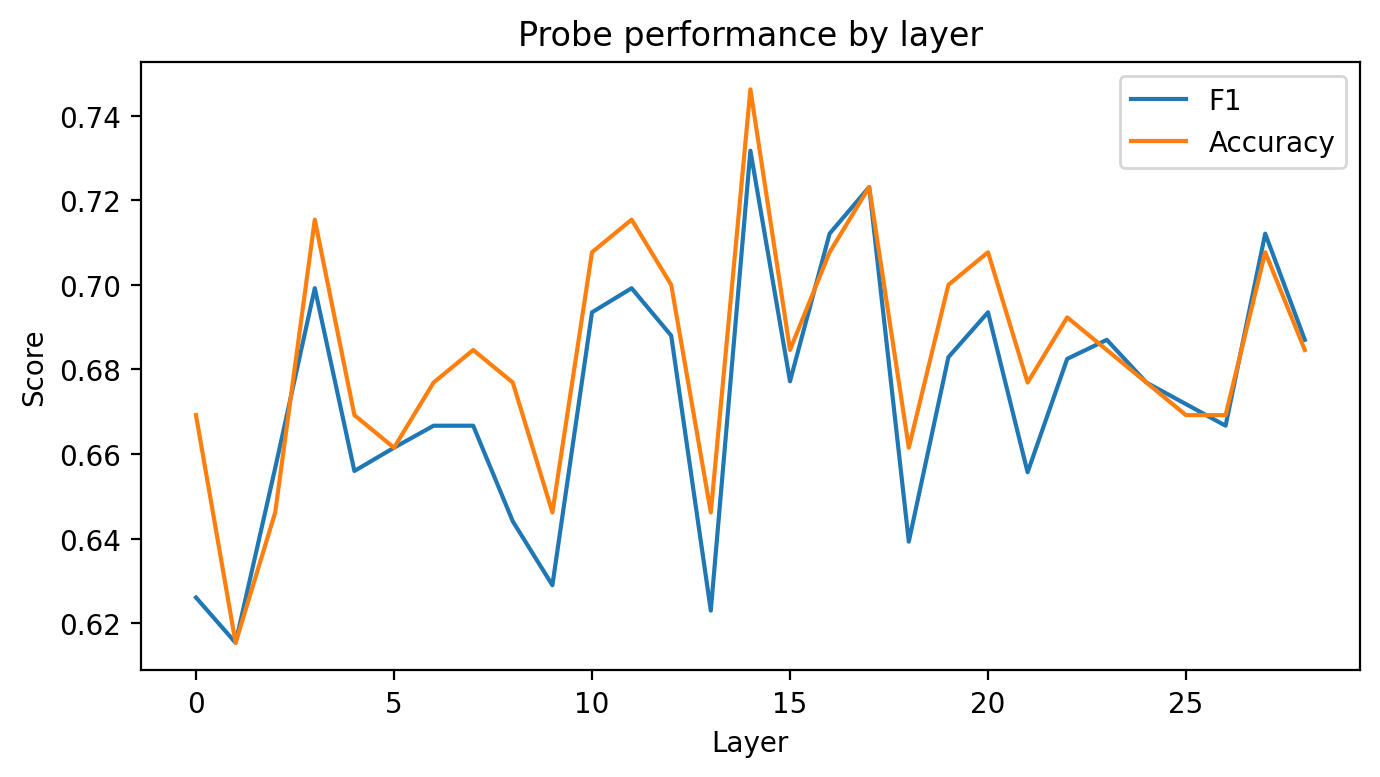

In [ ]:
import pandas as pd, matplotlib.pyplot as plt, os

df = pd.read_csv(os.path.join(OUTPUT_DIR, "results.csv")).sort_values("layer")
plt.figure(figsize=(7,4))
plt.plot(df["layer"], df["f1"], label="F1")
plt.plot(df["layer"], df["accuracy"], label="Accuracy")
plt.xlabel("Layer"); plt.ylabel("Score"); plt.title("Probe performance by layer")
plt.legend(); plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "performance_by_layer.png"), dpi=200)
plt.show()


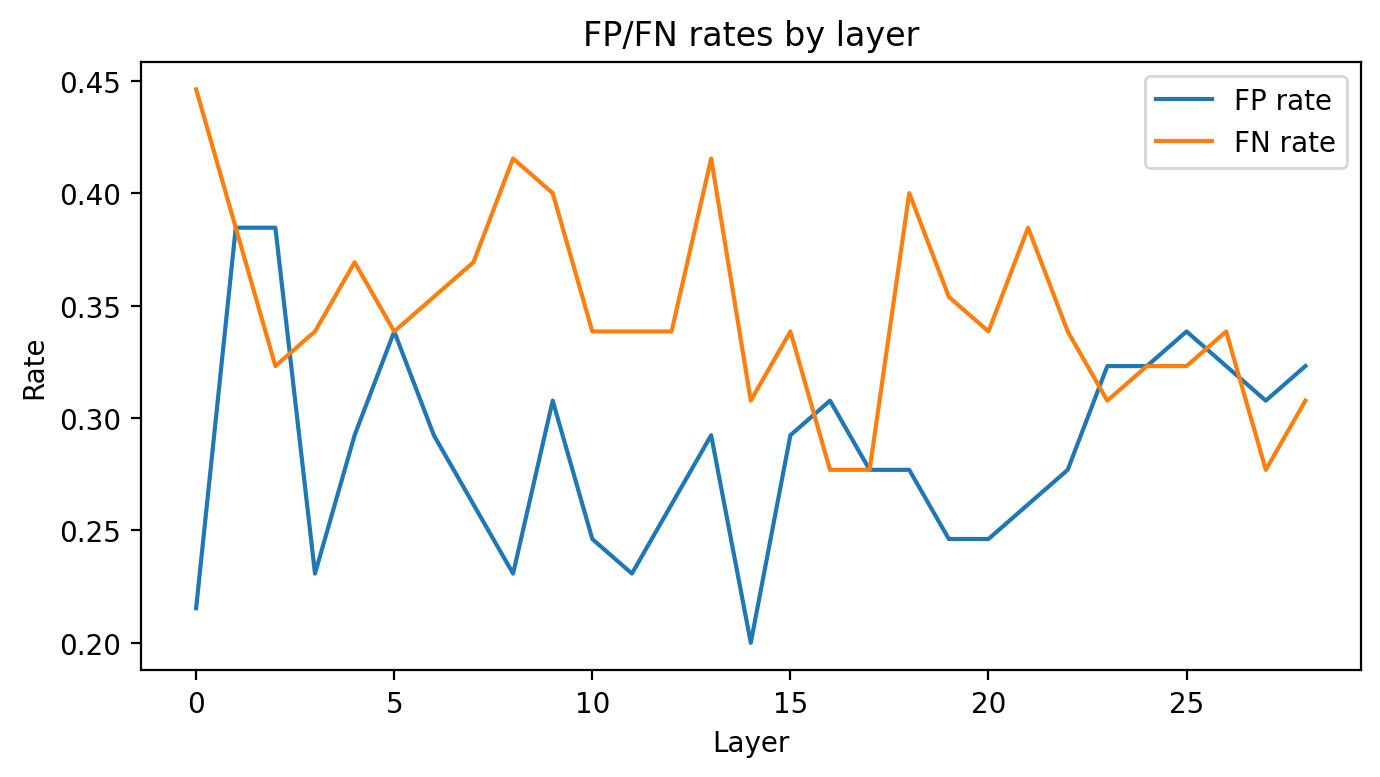

In [ ]:
import numpy as np
df["fp_rate"] = df["fp"] / (df["fp"] + df["tn"]).replace(0, np.nan)
df["fn_rate"] = df["fn"] / (df["fn"] + df["tp"]).replace(0, np.nan)

plt.figure(figsize=(7,4))
plt.plot(df["layer"], df["fp_rate"], label="FP rate")
plt.plot(df["layer"], df["fn_rate"], label="FN rate")
plt.xlabel("Layer"); plt.ylabel("Rate"); plt.title("FP/FN rates by layer")
plt.legend(); plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "fp_fn_rates_by_layer.png"), dpi=200)
plt.show()


In [ ]:
import os, pandas as pd

# Reload full TEST split (no truncation)
TEST_FULL = load_layerwise_split(TEST_FILE, quick=False, max_per_class=None)

# Read what the training loop wrote
csv_path = os.path.join(OUTPUT_DIR, "results.csv")
df = pd.read_csv(csv_path)

bad = []
for _, row in df.iterrows():
    lid = int(row["layer"])
    n_test_csv = int(row["n_test"])              # what your run evaluated on
    n_test_full = TEST_FULL[lid][0].shape[0]     # full test size for that layer
    if n_test_csv != n_test_full:
        bad.append((lid, n_test_csv, n_test_full))

if bad:
    print("⚠️ Some layers didn’t use the full test set (csv vs full):", bad[:5], "...")
else:
    print("✅ Test set sizes match the FULL dataset for all layers.")


✅ Test set sizes match the FULL dataset for all layers.


In [ ]:
import numpy as np

TRAIN_FULL = load_layerwise_split(TRAIN_FILE, quick=False, max_per_class=None)

mismatch = []
for _, row in df.iterrows():
    lid = int(row["layer"])
    Xtr_full, ytr_full = TRAIN_FULL[lid]
    # Expected balanced size = 2 * min(class counts)
    c0 = (ytr_full==0).sum(); c1 = (ytr_full==1).sum()
    expected_balanced = 2 * min(c0, c1)
    if int(row["n_train"]) != expected_balanced:
        mismatch.append((lid, int(row["n_train"]), expected_balanced))

if mismatch:
    print("ℹ️ Train n differs from expected balanced size (ok if you changed BALANCE_TRAIN_1_TO_1):", mismatch[:5], "...")
else:
    print("✅ Train sizes match the expected 1:1 balancing for all layers.")


✅ Train sizes match the expected 1:1 balancing for all layers.


## 7) Sanity checks & troubleshooting
- If label cardinality is 1 after filtering, recheck `KEEP_UNUSED_ZERO` and your label source.
- If shapes mismatch between train/test, ensure both files contain `[N, L, D]` in the same order.
- For very imbalanced data, 1:1 under-sampling improves F1 stability; you can try over-sampling as an alternative.
